## 基于多树GP的特征工程（Feature Construction）

[单树和多树的区别](./单树与多树GP.md)

在机器学习中，特征工程是非常重要的一环。特征工程的目的是从原始数据中提取出更有用的特征，以提高机器学习算法的性能。  
特征工程的方法有很多，比如特征降维（PCA、ICA、LDA）、特征选择、特征构造等。其中，特征构造是指从原始数据中构造出新的特征，以提高机器学习算法的性能。  
特征构造的方法有很多，比如多项式特征构造、基于树的特征构造、基于聚类的特征构造、基于神经网络的特征构造等。  
本文将介绍如何使用遗传编程（GP）来进行特征构造。遗传编程是一种进化算法，基于树结构演化，它很适合用于构造机器学习算法所需的特征。  

### 评估函数
特征工程是指遗传编程（GP）用于构造机器学习算法所需的特征，而后续的预测操作由机器学习算法来执行。因此，评估函数内部需要内置机器学习算法或特征质量评估函数。
值得一提的是，如果使用机器学习算法进行评估，为了避免过拟合，最好使用交叉验证误差来评估特征工程的效果。

In [1]:
# pip install scikit-learn
from sklearn.datasets import load_iris # 鸢尾花分类数据集

# 输入为X，输出为y
X, y = load_iris(return_X_y=True)

# 特征工程评估函数,参数为一组特征工程方案
# 求解问题的目标是最大化分类精度
def evalFeatureEngineering(individuals):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in X])
    """
    对每个特征工程方案(ind),使用gp.compile将其编译成可执行的函数
    将这个函数应用到每条数据记录(record)上,生成新的特征值
    所有新生成的特征被收集到new_features列表中
    """

    # 转置特征矩阵为标准格式
    new_features = np.transpose(np.array(new_features))

    # 使用决策树分类器，这里选择决策树是因为它能够处理非线性关系,适合评估特征的有效性。
    clf = DecisionTreeClassifier()
    clf.fit(new_features, y)

    # 使用交叉验证计算误差
    # 5折交叉验证评估模型性能
    scores = cross_val_score(clf, new_features, y, cv=5)

    # 返回平均分类精度
    return scores.mean(),

### 多树GP 个体表示
实现多树GP的方法有很多，最简单的方式是使用列表结构来表示一个个体，列表中的每个元素都是一棵树。
当然，为了后续的可扩展性，更建议创建一个类来表示个体，类中包含一个列表，列表中的每个元素都是一棵树。不过，这里为了简单起见，我们直接使用列表结构。

In [ ]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# 创建GP框架的基本组件
# 输入参数数量等于原始特征数量(X.shape[1])
pset = gp.PrimitiveSet("MAIN", X.shape[1])
pset.addPrimitive(operator.add, 2) # # 加法,接受2个参数
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
# 添加随机常数生成器,范围[-1,1]
pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)

# 创建一个适应度类和个体类，个体由多棵树组成
# 定义适应度,权重为1表示最大化目标
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/home/glk/project/anaconda3/lib/python3.11/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


### 交叉/变异算子
对于多树GP，很明显我们还需要自己定义交叉和变异算子。这里我们对DEAP中的交叉和变异算子进行简单包装，将其改造成能够处理多棵树的列表结构的算子。

In [3]:
toolbox = base.Toolbox()
# 注册表达式生成器,生成深度在1-6之间的树
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=6)


# 初始化每个个体为一个包含多棵树的列表
def initIndividual(container, func, size):
    # 初始化个体函数,生成size个树（多少个特征）组成的列表
    return container(gp.PrimitiveTree(func()) for _ in range(size))


# 定义交叉操作:遍历两个父代个体的对应树进行交叉
def cxOnePointListOfTrees(ind1, ind2):
    for idx, (tree1, tree2) in enumerate(zip(ind1, ind2)):
        HEIGHT_LIMIT = 5 # 限制树高以防止表达式过于复杂
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        tree1, tree2 = dec(gp.cxOnePoint)(tree1, tree2)
        ind1[idx], ind2[idx] = tree1, tree2
    return ind1, ind2

# 定义变异操作:对个体中的每棵树进行变异，随机改变个体中的树节点，保持树高限制
def mutUniformListOfTrees(individual, expr, pset):
    for idx, tree in enumerate(individual):
        HEIGHT_LIMIT = 5
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        tree, = dec(gp.mutUniform)(tree, expr=expr, pset=pset)
        individual[idx] = tree
    return (individual,)


toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)  # 假设我们创建3个特征，每个个体3棵树
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, pset=pset)
toolbox.register("compile", gp.compile, pset=pset)

通过一个具体的例子来解释遗传编程(GP)是如何解决鸢尾花分类问题的：

想象我们有一朵鸢尾花的原始数据：
- 萼片长度(x1) = 5.1
- 萼片宽度(x2) = 3.5
- 花瓣长度(x3) = 1.4
- 花瓣宽度(x4) = 0.2

GP的目标是找到能够更好区分不同品种鸢尾花的新特征。它通过组合这些原始特征来创造新特征。让我们看看它是如何工作的：

1. 为什么需要加减乘法？
假设GP生成了这样一个特征表达式：
```python
新特征 = (x1 * x2) - (x3 + x4)
```
将数值代入：
```python
新特征 = (5.1 * 3.5) - (1.4 + 0.2)
      = 17.85 - 1.6
      = 16.25
```

这个新特征可能比单独使用原始特征更有区分性，因为它：
- 通过乘法捕捉了萼片长度和宽度的相互关系
- 通过减法突出了萼片特征与花瓣特征的差异
- 通过加法合并了花瓣的整体特征

2. GP如何自动发现好的特征？
GP会同时尝试多种特征组合方案。比如：

方案1：
```python
新特征1 = x1 * x2        # 萼片面积
新特征2 = x3 * x4        # 花瓣面积
新特征3 = (x1/x2)/(x3/x4) # 萼片与花瓣的形状比
```

方案2：
```python
新特征1 = x1 + x2 + x3 + x4  # 整体大小
新特征2 = x1/x3              # 萼片长度与花瓣长度比
新特征3 = x2/x4              # 萼片宽度与花瓣宽度比
```

GP通过评估函数(evalFeatureEngineering)测试这些方案的效果：
1. 用这些新特征训练决策树
2. 通过交叉验证计算分类准确率
3. 准确率越高的方案越可能被保留并产生下一代

随着进化过程的进行：
- 好的特征组合会被保留（比如能反映花的形状比例的特征）
- 差的特征组合会被淘汰（比如过于复杂或无意义的组合）
- 通过交叉和变异，可能发现更好的特征组合

比如，如果GP发现"萼片面积/花瓣面积"这个特征非常有效，它可能会产生更多类似的特征：
```python
特征变体1 = (x1 * x2) / (x3 * x4)     # 原始版本
特征变体2 = (x1 * x2 + 1) / (x3 * x4) # 稍作修改
特征变体3 = (x1 * x2) / (x3 * x4 + 1) # 另一种修改
```

这就是为什么需要这些基本运算：
- 加法(+)：合并特征，计算总量
- 减法(-)：计算特征差异
- 乘法(*)：计算面积、体积等复合特征
- 取负(neg)：转换特征方向
- 随机常数：微调特征计算

通过这种方式，GP能够：
1. 自动发现有意义的特征组合
2. 保留有效的特征模式
3. 不断优化特征表达式
4. 最终找到一组能够更好区分鸢尾花品种的新特征

这比人工尝试所有可能的特征组合要高效得多，因为GP能够通过进化算法自动探索和优化特征空间。

最后，演化流程与传统的GP算法没有区别。直接运行即可。

In [4]:
# 运行遗传编程算法
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)

# 统计和日志
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=lambda ind: max([tree.height for tree in ind]))
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
print('Best individual is:', [str(tree) for tree in best_ind])
print('With fitness:', best_ind.fitness.values)

   	      	                             fitness                             	                    size                   
   	      	-----------------------------------------------------------------	-------------------------------------------
gen	nevals	avg   	gen	max     	min     	nevals	std      	avg	gen	max	min	nevals	std
0  	50    	0.9112	0  	0.966667	0.693333	50    	0.0575413	4.3	0  	6  	1  	50    	1.5
1  	41    	0.9372	1  	0.966667	0.72    	41    	0.0396449	3.82	1  	6  	2  	41    	1.43792
2  	39    	0.942 	2  	0.973333	0.76    	39    	0.0351821	3.82	2  	6  	1  	39    	1.51908
3  	46    	0.946267	3  	0.986667	0.826667	46    	0.0264797	3.8 	3  	6  	1  	46    	1.37113
4  	50    	0.934933	4  	0.993333	0.493333	50    	0.072499 	3.78	4  	6  	1  	50    	1.46   
5  	47    	0.9376  	5  	0.98    	0.693333	47    	0.0430351	4.06	5  	6  	1  	47    	1.31773
6  	46    	0.940933	6  	0.98    	0.806667	46    	0.0290596	4.28	6  	6  	1  	46    	1.14961
7  	46    	0.943867	7  	0.98    	0.78    	46    

分析运行结果：

1. 进化过程:
- 运行了10代
- 每代评估约40-50个个体
- 分类准确率从第0代的平均0.91提升到最后的0.95
- 最佳个体达到0.993的准确率(99.3%)

2. 最优解:
生成了3个新特征:
- 特征1: `add(-0.158, sub(ARG0, ARG2))`
- 特征2: 复杂的多层嵌套运算,结合了ARG0-3的非线性组合
- 特征3: `mul(sub(ARG3, sub(ARG0, ARG2)), neg(-0.478))`

3. 收敛性:
- 从第3代开始性能就相对稳定
- 种群大小和基因操作参数设置合理,算法收敛良好
- 最后几代的标准差较小,说明种群趋于一致

这个结果表明特征工程成功提升了分类性能,最终准确率达到99%以上。

当然，最后也可以利用NetworkX库来对所有GP树进行可视化。

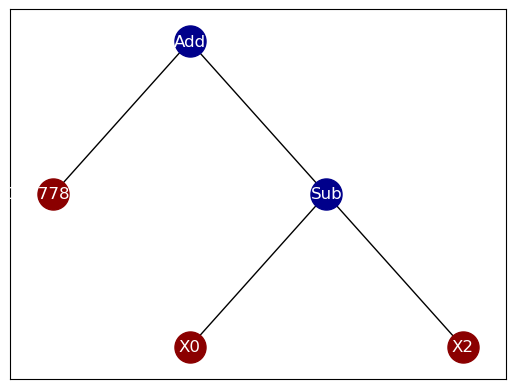

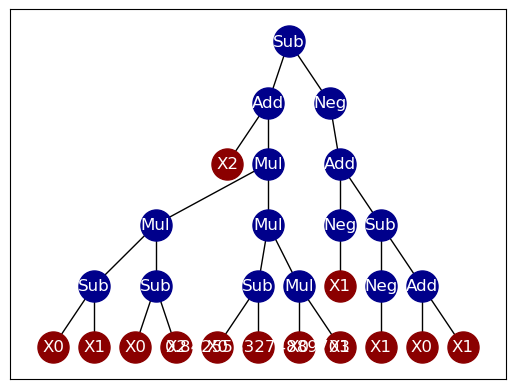

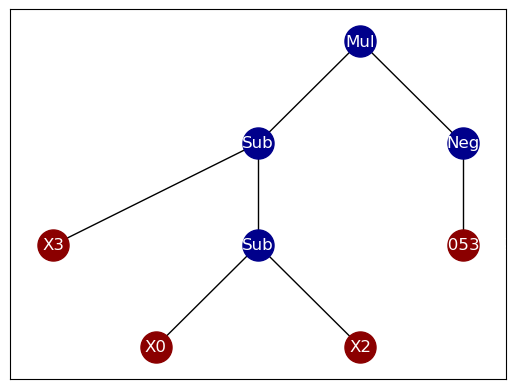

In [5]:
from matplotlib import pyplot as plt
import networkx as nx
from deap.gp import graph
from networkx.drawing.nx_agraph import graphviz_layout

function_name = {
    'add': 'Add',
    'sub': 'Sub',
    'mul': 'Mul',
    'neg': 'Neg'
}


def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False


def plot_a_tree(tree=hof[0]):
    red_nodes = []
    purple_nodes = []
    blue_nodes = []
    for gid, g in enumerate(tree):
        if (
                hasattr(g, "value")
                and isinstance(g.value, str)
                and g.value.startswith("ARG")
        ):
            g.value = g.value.replace("ARG", "X")

        if g.name in function_name:
            g.name = function_name[g.name]

        if hasattr(g, "value") and (
                is_number(g.value)
                or (g.value.startswith("X") and int(g.value[1:]) < X.shape[1])
        ):
            # 基础节点
            red_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("X"):
            g.value = "$\phi$" + str(int(g.value.replace("X", "")) - X.shape[1] + 1)
            purple_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("$\phi$"):
            purple_nodes.append(gid)
        else:
            # 深蓝色节点
            blue_nodes.append(gid)
    nodes, edges, labels = graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")
    red_nodes_idx = [nodes.index(n) for n in nodes if n in red_nodes]
    purple_nodes_idx = [nodes.index(n) for n in nodes if n in purple_nodes]
    blue_nodes_idx = [nodes.index(n) for n in nodes if n in blue_nodes]
    nx.draw_networkx_nodes(
        g, pos, nodelist=red_nodes_idx, node_color="darkred", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=purple_nodes_idx, node_color="indigo", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=blue_nodes_idx, node_color="darkblue", node_size=500
    )
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_color="white")


for tree in hof[0]:
    plot_a_tree(tree)
    plt.show()